In [0]:
# !wget https://huseinhouse-storage.s3-ap-southeast-1.amazonaws.com/reinforcement-learning/train_8M.csv
# !wget https://huseinhouse-storage.s3-ap-southeast-1.amazonaws.com/reinforcement-learning/transactions.csv
# !wget https://huseinhouse-storage.s3-ap-southeast-1.amazonaws.com/reinforcement-learning/holidays_events.csv
# !wget https://huseinhouse-storage.s3-ap-southeast-1.amazonaws.com/reinforcement-learning/items.csv
# !wget https://huseinhouse-storage.s3-ap-southeast-1.amazonaws.com/reinforcement-learning/oil.csv
# !wget https://huseinhouse-storage.s3-ap-southeast-1.amazonaws.com/reinforcement-learning/stores.csv
# !wget https://huseinhouse-storage.s3-ap-southeast-1.amazonaws.com/reinforcement-learning/recmetrics.zip
# !unzip recmetrics.zip

In [2]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5407431782352422390, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 7156835588512369600
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 2996336737461207986
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 13962933044
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7744170219303242052
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [3]:
!ls

holidays_events.csv  __MACOSX  recmetrics      sample_data  train_8M.csv
items.csv	     oil.csv   recmetrics.zip  stores.csv   transactions.csv


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from datetime import datetime, timedelta
import tensorflow as tf
import random
sns.set()

items = pd.read_csv("items.csv")
holiday_events = pd.read_csv("holidays_events.csv")
stores = pd.read_csv("stores.csv")
oil = pd.read_csv("oil.csv")
transactions = pd.read_csv("transactions.csv",parse_dates=['date'])
train = pd.read_csv("train_8M.csv", nrows = 500000, parse_dates=['date'])

In [0]:
stores = train['store_nbr'].values
items = train['item_nbr'].values
reward = train['unit_sales'].values

In [6]:
encoded = LabelEncoder().fit_transform(items)
items_unique = np.unique(items)
items_unique

array([  96995,  103501,  103520, ..., 1114567, 1114749, 1118683])

In [0]:
from sklearn.model_selection import train_test_split

train_stores, test_stores, train_items, test_items, train_reward, test_reward, train, test = train_test_split(stores, encoded, reward,
                                                                                                              train, test_size = 0.25,
                                                                                                             shuffle = False)

In [0]:
from collections import deque
import random

LEARNING_RATE = 1e-5
LAYER_SIZE = 256
OUTPUT_SIZE = np.unique(items).shape[0]
STATE_SIZE = np.unique(stores).shape[0]
SEQ_LEN = 5

class Model:
  def __init__(self, name):
    with tf.variable_scope(name):
      self.X = tf.placeholder(tf.int32, [None, None])
      self.Y = tf.placeholder(tf.float32, [None, OUTPUT_SIZE])
      cell = tf.nn.rnn_cell.LSTMCell(LAYER_SIZE, state_is_tuple = False)
      embeddings = tf.Variable(tf.random_uniform([STATE_SIZE, LAYER_SIZE], -1, 1))
      embedded = tf.nn.embedding_lookup(embeddings, self.X)
      self.hidden_layer = tf.placeholder(tf.float32, (None, 2 * LAYER_SIZE))
      output, self.last_state = tf.nn.dynamic_rnn(inputs=embedded,cell=cell,
                                                      dtype=tf.float32,
                                                      initial_state=self.hidden_layer)
      self.logits = tf.layers.dense(output[:,-1], OUTPUT_SIZE)
      self.cost = tf.reduce_sum(tf.square(self.Y - self.logits))
      self.optimizer = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(
          self.cost
      )
      
class Agent:

  EPSILON = 0.5
  DECAY_RATE = 0.005
  MIN_EPSILON = 0.1
  GAMMA = 0.95
  MEMORIES = deque()
  COPY = 200
  T_COPY = 0
  MEMORY_SIZE = 300

  def __init__(self):
    tf.reset_default_graph()
    self.model = Model('from')
    self.model_negative = Model('to')
    self.sess = tf.InteractiveSession()
    self.sess.run(tf.global_variables_initializer())
    self.trainable = tf.trainable_variables()
  
  def _assign(self):
    from_w = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='from')
    to_w = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='to')
    for i in range(len(from_w)):
      assign_op = to_w[i].assign(from_w[i])
      self.sess.run(assign_op)
  
  def _memorize(self, state, action, reward, new_state, done, memory):
    self.MEMORIES.append((state, action, reward, new_state, done, memory))
    if len(self.MEMORIES) > self.MEMORY_SIZE:
      self.MEMORIES.popleft()
  
  def _select_action(self, state, memories):
    if np.random.rand() < self.EPSILON:
      action = np.random.randint(OUTPUT_SIZE, size = (len(state)))
    else:
      action, memories = self.predict(state, memories)
      action = np.argmax(action, axis = 1)
    return action, memories
  
  def _construct_memories(self, replay):
    states = np.array([a[0] for a in replay])
    new_states = np.array([a[3] for a in replay])
    memories = np.array([a[-1] for a in replay])
    Q, _ = self.predict(states, memories)
    Q_new, _ = self.predict(new_states, memories)
    Q_new_negative = self.sess.run(self.model_negative.logits, feed_dict={self.model_negative.X:new_states,
                                                                         self.model_negative.hidden_layer:memories})
    replay_size = len(replay)
    X = []
    Y = np.empty((replay_size, OUTPUT_SIZE))
    MEMORIES = np.empty((replay_size, 2 * LAYER_SIZE))
    for i in range(replay_size):
      state_r, action_r, reward_r, new_state_r, done_r, rnn_memory = replay[i]
      target = Q[i]
      target[action_r] = reward_r
      if not done_r:
          target[action_r] += self.GAMMA * Q_new_negative[i, np.argmax(Q_new[i])]
      X.append(state_r)
      Y[i] = target
      MEMORIES[i] = rnn_memory
    return X, Y, MEMORIES
    
  def predict(self, inputs, memories):
    return self.sess.run([self.model.logits, self.model.last_state], feed_dict={self.model.X:inputs,
                                                                                 self.model.hidden_layer: memories})

In [9]:
agent = Agent()

W0725 17:12:27.443568 139932452435840 deprecation.py:323] From <ipython-input-8-73e574562486>:15: LSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W0725 17:12:27.445487 139932452435840 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f446cf83898>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0725 17:12:27.459148 139932452435840 deprecation.py:323] From <ipython-input-8-73e574562486>:21: dynamic_rnn (from tensorflow.python.ops.rnn) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
W0725 17:12:27.513314 139932452435840 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:12

In [0]:
slide_train_stores = [train_stores[i: i + SEQ_LEN] for i in range(len(train_stores) - SEQ_LEN)]
train_pivoted = train.pivot_table(index='store_nbr', columns='item_nbr', values='unit_sales').fillna(0)

In [11]:
from tqdm import tqdm
epoch = 5
batch_size = 128

for e in range(epoch):
  pbar = tqdm(
      range(0, len(slide_train_stores) - 1, batch_size), desc = 'train minibatch loop'
    )
  loss = []
  for i in pbar:
    index = min(i + batch_size, len(slide_train_stores) - 1)
    if (agent.T_COPY + 1) % agent.COPY == 0:
      agent._assign()
    state = slide_train_stores[i: index]
    init_value = np.zeros((len(state), 2 * LAYER_SIZE))
    action, init_value = agent._select_action(state, init_value)
    next_state = slide_train_stores[i + 1: index + 1]
    for no, a in enumerate(action):
      if a >= train_pivoted.shape[1]:
        r = 0
      else:
        r = train_pivoted.loc[slide_train_stores[i + no][-1]].iloc[a]
      agent._memorize(state[no], a, r, next_state[no], r < 1, init_value[-1])
    
    replay = random.sample(agent.MEMORIES, min(len(agent.MEMORIES), batch_size))
    X, Y, MEMORIES = agent._construct_memories(replay)
    cost, _ = agent.sess.run([agent.model.cost, agent.model.optimizer], 
                               feed_dict={agent.model.X: X, agent.model.Y:Y, agent.model.hidden_layer:MEMORIES}) 
    agent.T_COPY += 1
    agent.EPSILON = agent.MIN_EPSILON + (1.0 - agent.MIN_EPSILON) * np.exp(-agent.DECAY_RATE * i)
      
    pbar.set_postfix(cost = cost)
    loss.append(cost)
  print('\nepoch: %d, average lost: %f'%(e + 1, np.mean(loss)))

train minibatch loop:   0%|          | 2/2930 [00:00<02:32, 19.20it/s, cost=9.5e+4] 

epoch: 1, average lost: 22453.000000


train minibatch loop:   0%|          | 1/2930 [00:00<05:20,  9.13it/s, cost=3.84e+4]

epoch: 2, average lost: 118963.820312


train minibatch loop:   0%|          | 2/2930 [00:00<04:28, 10.91it/s, cost=1.49e+5]

epoch: 3, average lost: 138000.234375


train minibatch loop:   0%|          | 2/2930 [00:00<03:49, 12.75it/s, cost=1.54e+6]

epoch: 4, average lost: 143218.812500


train minibatch loop: 100%|██████████| 2930/2930 [04:20<00:00, 11.25it/s, cost=1.99e+3]

epoch: 5, average lost: 198387.765625


In [12]:
test_cp = test.copy().groupby('store_nbr')['item_nbr'].agg({'actual': (lambda x: list(set(x)))})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


In [0]:
def get_users_predictions(user_id, n):
  init_value = np.zeros((1, 2 * LAYER_SIZE))
  p = agent.sess.run(agent.model.logits, feed_dict = {agent.model.X: [[user_id]], agent.model.hidden_layer: init_value})[0]
  p = p.argsort()[-n:][::-1]
  return [items_unique[i] for i in p]

In [17]:
recs = []
for user in test_cp.index:
    cf_predictions = get_users_predictions(user + 1, 30)
    recs.append(cf_predictions)
        
test_cp['cf_predictions'] = recs
test_cp.head()

,actual,cf_predictions
store_nbr,,
1,"[174081, 1058820, 862213, 819206, 460804, 8192...","[329362, 738219, 940592, 364606, 1047679, 1659..."
2,"[174081, 460804, 862213, 819206, 1058820, 8192...","[329362, 738219, 940592, 364606, 1047679, 1659..."
3,"[174081, 460804, 862213, 819206, 1058820, 8192...","[329362, 738219, 940592, 364606, 1047679, 1659..."
4,"[174081, 460804, 862213, 819206, 1058820, 8192...","[329362, 738219, 940592, 846565, 364606, 10476..."
5,"[174081, 460804, 862213, 819206, 1058820, 8192...","[329362, 738219, 940592, 364606, 1047679, 1659..."


In [18]:
popularity_recs = train.item_nbr.value_counts().head(30).index.tolist()

recs = []
for user in test_cp.index:
    pop_predictions = popularity_recs
    recs.append(pop_predictions)
        
test_cp['pop_predictions'] = recs
test_cp.head()

,actual,cf_predictions,pop_predictions
store_nbr,,,
1,"[174081, 1058820, 862213, 819206, 460804, 8192...","[329362, 738219, 940592, 364606, 1047679, 1659...","[222879, 314384, 559870, 564533, 502331, 27352..."
2,"[174081, 460804, 862213, 819206, 1058820, 8192...","[329362, 738219, 940592, 364606, 1047679, 1659...","[222879, 314384, 559870, 564533, 502331, 27352..."
3,"[174081, 460804, 862213, 819206, 1058820, 8192...","[329362, 738219, 940592, 364606, 1047679, 1659...","[222879, 314384, 559870, 564533, 502331, 27352..."
4,"[174081, 460804, 862213, 819206, 1058820, 8192...","[329362, 738219, 940592, 846565, 364606, 10476...","[222879, 314384, 559870, 564533, 502331, 27352..."
5,"[174081, 460804, 862213, 819206, 1058820, 8192...","[329362, 738219, 940592, 364606, 1047679, 1659...","[222879, 314384, 559870, 564533, 502331, 27352..."


In [19]:
recs = []
for user in test_cp.index:
    random_predictions = train.item_nbr.sample(30).values.tolist()
    recs.append(random_predictions)
        
test_cp['random_predictions'] = recs
test_cp.head()

,actual,cf_predictions,pop_predictions,random_predictions
store_nbr,,,,
1,"[174081, 1058820, 862213, 819206, 460804, 8192...","[329362, 738219, 940592, 364606, 1047679, 1659...","[222879, 314384, 559870, 564533, 502331, 27352...","[1047679, 468265, 892076, 255161, 172343, 8903..."
2,"[174081, 460804, 862213, 819206, 1058820, 8192...","[329362, 738219, 940592, 364606, 1047679, 1659...","[222879, 314384, 559870, 564533, 502331, 27352...","[859932, 314880, 525887, 750855, 252698, 95709..."
3,"[174081, 460804, 862213, 819206, 1058820, 8192...","[329362, 738219, 940592, 364606, 1047679, 1659...","[222879, 314384, 559870, 564533, 502331, 27352...","[518094, 212550, 119023, 940585, 1087270, 8435..."
4,"[174081, 460804, 862213, 819206, 1058820, 8192...","[329362, 738219, 940592, 846565, 364606, 10476...","[222879, 314384, 559870, 564533, 502331, 27352...","[115891, 938657, 1084437, 311994, 402174, 8127..."
5,"[174081, 460804, 862213, 819206, 1058820, 8192...","[329362, 738219, 940592, 364606, 1047679, 1659...","[222879, 314384, 559870, 564533, 502331, 27352...","[510054, 365264, 261700, 864510, 633997, 50206..."


In [0]:
actual = test_cp.actual.values.tolist()
cf_predictions = test_cp.cf_predictions.values.tolist()
pop_predictions = test_cp.pop_predictions.values.tolist()
random_predictions = test_cp.random_predictions.values.tolist()

In [21]:
import recmetrics

pop_mark = []
for K in np.arange(1, 31):
    pop_mark.extend([recmetrics.mark(actual, pop_predictions, k=K)])
pop_mark

[0.000984488736644838,
 0.001968977473289676,
 0.0029534662099345134,
 0.003937954946579352,
 0.004922443683224189,
 0.005906932419869027,
 0.006891421156513865,
 0.007875909893158704,
 0.008860398629803541,
 0.009844887366448379,
 0.010829376103093216,
 0.011813864839738054,
 0.012772130258608726,
 0.01375474590112684,
 0.014737486416586733,
 0.01572033619587069,
 0.01670328238441116,
 0.01768631427006855,
 0.018669422832093687,
 0.01965260040284982,
 0.02063584041007684,
 0.02161913717773194,
 0.02260248577012573,
 0.02358588186852998,
 0.024569321672463843,
 0.02555280181996352,
 0.02653631932261673,
 0.027519871512198205,
 0.028503455996506003,
 0.02946992619792526]

In [22]:
random_mark = []
for K in np.arange(1, 31):
    random_mark.extend([recmetrics.mark(actual, random_predictions, k=K)])
random_mark

[0.0007694192212448923,
 0.0014546349457042588,
 0.002075015862415885,
 0.002681979841179703,
 0.0032749529968326917,
 0.003833644867985616,
 0.00440586773828542,
 0.00501540224468292,
 0.005640295602433753,
 0.006181091495828676,
 0.006773290800521976,
 0.007371732096551141,
 0.007974484771406037,
 0.008478497138415458,
 0.00909414993134957,
 0.00961271808923553,
 0.010131009612957898,
 0.01068025759416344,
 0.01120374698306578,
 0.011739347846157043,
 0.012349787685785563,
 0.012932252861770748,
 0.01349754219680567,
 0.014079599409935866,
 0.014720680935046516,
 0.015287391704993792,
 0.01581510026682273,
 0.016355919045447774,
 0.016866444544095666,
 0.01750468038361333]

In [23]:
cf_mark = []
for K in np.arange(1, 31):
    cf_mark.extend([recmetrics.mark(actual, cf_predictions, k=K)])
cf_mark

[0.0007325848176000715,
 0.0013744768251154746,
 0.0020725833492521,
 0.0027960689327697933,
 0.00353604775411643,
 0.004294861579330348,
 0.0050226936199574464,
 0.005741755846822267,
 0.006435976133303328,
 0.007136985582656643,
 0.007926012360135242,
 0.008644474470886024,
 0.00933443625625627,
 0.010085063830085372,
 0.010880019009490852,
 0.011639496329794784,
 0.01244774860070308,
 0.013147390082749455,
 0.013920503207586407,
 0.014735208788939375,
 0.015519803126433787,
 0.0163513755086271,
 0.017094608461794357,
 0.017874684630862298,
 0.018648314307821295,
 0.01949015350746875,
 0.020329021081471884,
 0.02112287036227087,
 0.021917552963231206,
 0.022785958376618697]

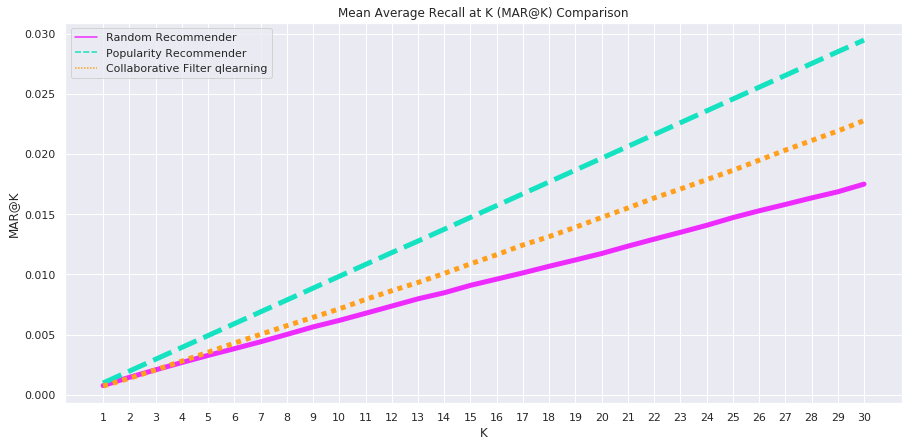

In [24]:
mark_scores = [random_mark, pop_mark, cf_mark]
index = range(1,30+1)
names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter qlearning']

fig = plt.figure(figsize=(15, 7))
recmetrics.mark_plot(mark_scores, model_names=names, k_range=index)

In [0]:
catalog = train.item_nbr.unique().tolist()
random_coverage = recmetrics.coverage(random_predictions, catalog)
pop_coverage = recmetrics.coverage(pop_predictions, catalog)
cf_coverage = recmetrics.coverage(cf_predictions, catalog)

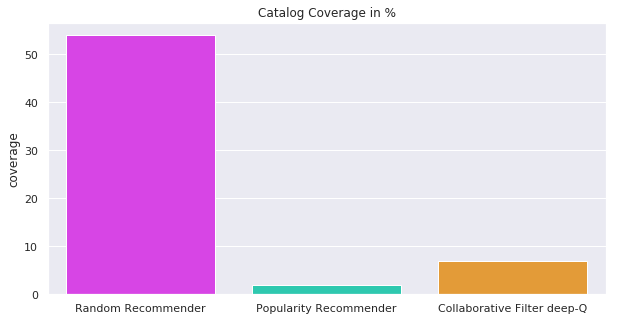

In [26]:
coverage_scores = [random_coverage, pop_coverage, cf_coverage]
model_names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter deep-Q']

fig = plt.figure(figsize=(10, 5))
recmetrics.coverage_plot(coverage_scores, model_names)